In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Input, AveragePooling1D, Dropout, Softmax
from keras.optimizers import Adam, Nadam
from keras.regularizers import L2
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, Callback, LambdaCallback
from keras.metrics import Metric
from tensorflow import keras

from time import perf_counter
import functools

In [3]:
stresses = ['Gm', 'Drought', 'Nutrient_Deficiency', 'Fs', 'Salinity']

In [4]:
csv_path = r'..\combined.csv'
df = pd.read_csv(csv_path)
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df.drop(columns=['Fungal_infection'], inplace=True, errors='ignore')
df[stresses] = df[stresses].astype(bool)

C:\Users\thead\AppData\Local\Temp\ipykernel_27180\1297277926.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


In [5]:
spec_cols = [col for col in df.columns if col[0] == 'X']

In [17]:
trait_cols = df.columns[list(df.columns).index(spec_cols[-1])+1:]

## PCA

In [20]:
df[trait_cols]

(23656, 35)

In [28]:
pca = PCA(n_components=10)
x_pca = pca.fit_transform(df[trait_cols].values)

In [29]:
pca.explained_variance_ratio_.cumsum()

array([0.67645515, 0.8515996 , 0.95720411, 0.97574504, 0.98486931,
       0.99101191, 0.99546313, 0.99799683, 0.99894417, 0.99946745])

## NN

array([[0.59168592, 0.45748283, 0.5556406 , ..., 0.49961503, 0.1788518 ,
        0.35386812],
       [0.54916771, 0.54878389, 0.43357593, ..., 0.55762903, 0.22246862,
        0.37287277],
       [0.55319733, 0.47042533, 0.40807592, ..., 0.56404209, 0.46298605,
        0.33154013],
       ...,
       [0.22052944, 0.34836485, 0.86988769, ..., 0.57610187, 0.35452432,
        0.33090534],
       [0.45560781, 0.66221538, 0.63585068, ..., 0.57791398, 0.47515626,
        0.4181094 ],
       [0.14611771, 0.54324547, 0.67781236, ..., 0.72834101, 0.31983212,
        0.27891245]])

In [54]:
x_pca = df[trait_cols].values

x_pca = (x_pca - x_pca.min(axis=0))/(x_pca.max(axis=0)-x_pca.min(axis=0))
y = df[stresses].values

x_train, x_val, y_train, y_val = train_test_split(x_pca, y, test_size=.2)

In [145]:
model = Sequential([
    Input((x_pca.shape[1],)),
    Dense(256, kernel_regularizer=L2(.001), activation='relu'),
    Dropout(.2),
    Dense(256, kernel_regularizer=L2(.001), activation='relu'),
    Dropout(.2),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.2),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.1),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.1),
    Dense(256, kernel_regularizer=L2(.00), activation='relu'),
    Dropout(.1),
    Dense(y.shape[1], activation='sigmoid'),
])

model.compile(optimizer=Nadam(1e-4), loss='binary_crossentropy')

In [146]:
start = perf_counter()

history = model.fit(
    cnn_reshape(x_train),
    y_train,
    epochs=100,
    validation_data=(cnn_reshape(x_val), y_val),
    batch_size=80,
)

print(perf_counter() - start)

Epoch 1/100
237/237 [==============================] - 4s 7ms/step - loss: 0.7057 - val_loss: 0.5851
Epoch 2/100
237/237 [==============================] - 2s 6ms/step - loss: 0.5053 - val_loss: 0.4309
Epoch 3/100
237/237 [==============================] - 2s 7ms/step - loss: 0.4167 - val_loss: 0.3800
Epoch 4/100
237/237 [==============================] - 2s 6ms/step - loss: 0.3714 - val_loss: 0.3404
Epoch 5/100
237/237 [==============================] - 2s 6ms/step - loss: 0.3433 - val_loss: 0.3202
Epoch 6/100
237/237 [==============================] - 2s 6ms/step - loss: 0.3233 - val_loss: 0.3020
Epoch 7/100
237/237 [==============================] - 2s 7ms/step - loss: 0.3053 - val_loss: 0.2846
Epoch 8/100
237/237 [==============================] - 2s 6ms/step - loss: 0.2908 - val_loss: 0.2694
Epoch 9/100
237/237 [==============================] - 2s 7ms/step - loss: 0.2799 - val_loss: 0.2581
Epoch 10/100
237/237 [==============================] - 1s 6ms/step - loss: 0.2695 - val_lo

In [147]:
y_pred = model.predict(x_val)

(~y_val).mean(), ((y_pred > .5) == y_val).mean()

148/148 [==============================] - 0s 1ms/step


(0.8374894336432798, 1.0)

Text(0.5, 1.0, 'NN Loss over Training')

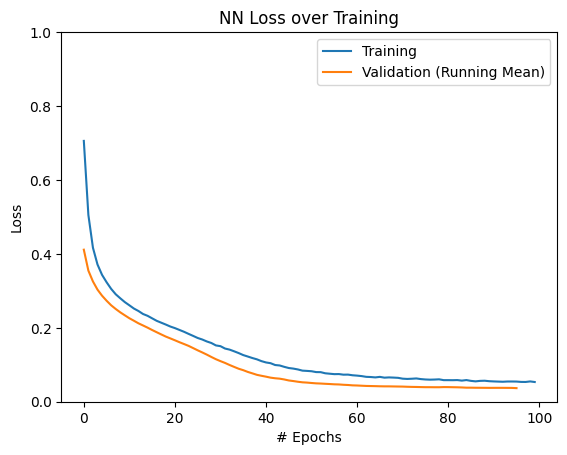

In [148]:
fig = plt.figure()
ax = plt.gca()

ax.plot(history.history['loss'], label='Training')
ax.plot(
    np.convolve(np.array(history.history['val_loss']), np.ones(5)/5, mode='valid'),
    label='Validation (Running Mean)'
)
ax.legend()
ax.set_xlabel('# Epochs')
ax.set_ylabel('Loss')
ax.set_ylim((0, 1))
ax.set_title('NN Loss over Training')

## Interpretation

In [149]:
with tf.GradientTape() as tape:
    x = tf.Variable(x_pca)
    outs = model(x)
    grads = tape.gradient(outs, x)
    sensitivity = (grads * x).numpy()
    sensitivity = (sensitivity-sensitivity.min(axis=0))/(sensitivity.max(axis=0)-sensitivity.min(axis=0))

In [152]:
s_z = np.empty((len(stresses), sensitivity.shape[1]))
for i in range(len(stresses)):
    s_i = y[:,i]
    s_z[i] = np.abs(sensitivity[s_i].mean(axis=0) - sensitivity[~s_i].mean(axis=0))/sensitivity[~s_i].std(axis=0)
s_z

array([[4.83148079e-02, 1.65979927e-01, 1.44912266e-01, 1.38736688e-02,
        2.46772210e-02, 1.19300044e-01, 3.23751705e-01, 1.06833695e-01,
        1.81838097e-01, 9.05949800e-02, 7.99219521e-02, 3.97084875e-02,
        1.64327171e-03, 1.72671474e-02, 1.28238424e-01, 1.27859121e-01,
        2.05214616e-01, 1.77412590e-01, 3.62767368e-02, 2.76309334e-02,
        2.97387996e-02, 1.74875708e-02, 1.64502837e-01, 5.70859747e-02,
        6.03813687e-02, 5.87057845e-02, 5.52018474e-03, 1.09794209e-01,
        4.52096598e-01, 2.37079444e-01, 1.71035410e-01, 4.07594492e-02,
        3.98160456e-02, 1.64882489e-01, 6.18736929e-02],
       [3.93976969e-01, 8.23019283e-02, 2.77325278e-01, 1.04652082e-01,
        5.06766611e-01, 1.42227269e-01, 1.21592218e-01, 1.97056940e-02,
        5.52539811e-01, 1.12407755e-01, 5.22816579e-01, 5.53842526e-01,
        5.58532204e-01, 1.83065863e-01, 2.92999566e-01, 2.76557487e-01,
        2.85428312e-01, 8.07236347e-03, 7.53081032e-02, 1.56596757e-01,
       